<br>
<h1><center>Capstone Project: The Battle of Neighborhoods (Week 1-2)</center></h1>

<h4>About this Notebook</h4>
<br>created by <a href="https://github.com/Sherryl93/">@Sherryl93</a>
<h4><center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center></h4>

## Table of contents
* [Introduction - Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis & Results](#analysis-results)
* [Conclusion](#conclusion)

## Introduction -  Business Problem <a name="introduction"></a>

In this project we will try to find a **Optimal Location** to open the most happening business in Taiwan which is **Convenience Store**. 

Specifically, we will targeted districts that belong to Taipei and New Taipei City. 

We will choose based on three criteria: 
    - Population
    - Area size 
    - Number existing Convinience store

We will use our data science to generate a few most promissing districts based on this criteria. 

Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders


## Data <a name="data"></a>

Our Districts database Source : https://en.wikipedia.org/wiki/List_of_townships/cities_and_districts_in_Taiwan

Based on definition of our problem, factors that will influence our decission are:
* Number of Population in each districts
* Area Size for each districts
* Sample Number of existing convinience store

Following data sources will be needed to extract/generate the required information:
* approximate latitude and longitude for each districts using  **geolocator**
* number of existing of convinience store **Foursquare API**

## Methodology <a name="methodology"></a>

### 1. Collect Inspection Data

In [73]:
#Libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

import math
from math import radians, cos, sin, asin, sqrt

# for ploting
import matplotlib.pyplot as plt
import seaborn as sns

!conda install -c conda-forge folium=0.5.0 --yes 
import folium

#!conda install -c conda-forge geopy --yes # uncomment this if you already have geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported')

Solving environment: / ^C
failed

CondaError: KeyboardInterrupt

Libraries imported


In [74]:
# fetch data from wikipedia and parse the HTML/XML 
res = requests.get("https://en.wikipedia.org/wiki/List_of_townships/cities_and_districts_in_Taiwan")
soup = BeautifulSoup(res.content,'lxml')
# extracting the raw table inside that webpage
table = soup.find('table', class_='wikitable sortable')

In [75]:
code_l = []
partof_l = []
english_n_l = []
type_l = []
pop_l = []
for tr in table.find_all('tr'):
    tds = tr.find_all('td')
    if not tds:
        continue
    code, partof, english_n, native_n, type_p, pop, area,pop_den, pop_2010,pop_change = [td.text.strip() for td in tds]
    #print(code,'|',partof,'|', english_n, '|', type_p, '|',pop)
    
    # append to list
    code_l.append(code)
    partof_l.append(partof)
    english_n_l.append(english_n)
    type_l.append(type_p)
    pop_l.append(pop)
    

In [76]:
## save to dataframe
df = pd.DataFrame.from_dict({'Code':code_l , 'PartOf':partof_l, 'English_Name': english_n_l, 'Type_P': type_l, 'Population':pop_l})
df.head()

,Code,PartOf,English_Name,Type_P,Population
0,65000010,New Taipei City,Banqiao District,District,"557,120"
1,65000020,New Taipei City,Sanchong District,District,"386,236"
2,65000030,New Taipei City,Zhonghe District,District,"413,067"
3,65000040,New Taipei City,Yonghe District,District,"220,619"
4,65000050,New Taipei City,Xinzhuang District,District,"420,684"


In [84]:
df.PartOf.unique()

array(['New Taipei City', 'Taipei City', 'Taoyuan City', 'Taichung City',
       'Tainan City', 'Kaohsiung City', 'Yilan County', 'Hsinchu County',
       'Miaoli County', 'Changhua County', 'Nantou County',
       'Yunlin County', 'Chiayi County', 'Pingtung County',
       'Taitung County', 'Hualien County', 'Penghu County',
       'Keelung City', 'Hsinchu City', 'Chiayi City', 'Kinmen County',
       'Lienchiang County'], dtype=object)

In [150]:
# restrict to Taipei & New Taipei City only
df_sub = df[df['PartOf'].isin(['New Taipei City', 'Taipei City'])]
print(df_sub.shape)
df_sub.head()

(41, 5)


,Code,PartOf,English_Name,Type_P,Population
0,65000010,New Taipei City,Banqiao District,District,"557,120"
1,65000020,New Taipei City,Sanchong District,District,"386,236"
2,65000030,New Taipei City,Zhonghe District,District,"413,067"
3,65000040,New Taipei City,Yonghe District,District,"220,619"
4,65000050,New Taipei City,Xinzhuang District,District,"420,684"


In [151]:
# Get rid of $ and , in the SAL-RATE, then convert it to a float
def find_lat_long(city_name):
    geolocator = Nominatim(user_agent="tw_explorer")
    location = geolocator.geocode(city_name)
    latitude = location.latitude
    longitude = location.longitude
    return pd.Series([city_name,latitude,longitude])

df_sub_lat_long = df_sub['English_Name'].apply(find_lat_long).rename(columns={0:'English_Name', 1: "Latitude",2: "Longitude"})
df_sub_merged = pd.concat([df_sub, df_sub_lat_long], axis=1, join='inner')
df_sub_merged = df_sub_merged.loc[:,~df_sub_merged.columns.duplicated()]
print(df_sub_merged.shape)
df_sub_merged.head()

(41, 7)


,Code,PartOf,English_Name,Type_P,Population,Latitude,Longitude
0,65000010,New Taipei City,Banqiao District,District,"557,120",25.009670,121.459099
1,65000020,New Taipei City,Sanchong District,District,"386,236",25.061486,121.488102
2,65000030,New Taipei City,Zhonghe District,District,"413,067",24.999397,121.498980
3,65000040,New Taipei City,Yonghe District,District,"220,619",25.009235,121.520070
4,65000050,New Taipei City,Xinzhuang District,District,"420,684",25.035772,121.450248


In [152]:
# drop mountain, beach and rural area
mountain_area = ['Datong District', 'Gongliao District', 'Jinshan District', 'Shenkeng District', 'Shiding District',
                 'Shimen District','Shuangxi District', 'Pingxi District', 'Ruifang District', 'Sanzhi District',
                 'Taishan District', 'Tamsui District','Wanli District', 'Wulai District', 'Pinglin District',
                 'Wugu District']

df_sub_merged = df_sub_merged[~(df_sub_merged['English_Name'].isin(mountain_area))].reset_index()
print(df_sub_merged.shape)
df_sub_merged

(25, 8)


,index,Code,PartOf,English_Name,Type_P,Population,Latitude,Longitude
0,0,65000010,New Taipei City,Banqiao District,District,"557,120",25.009670,121.459099
1,1,65000020,New Taipei City,Sanchong District,District,"386,236",25.061486,121.488102
2,2,65000030,New Taipei City,Zhonghe District,District,"413,067",24.999397,121.498980
3,3,65000040,New Taipei City,Yonghe District,District,"220,619",25.009235,121.520070
4,4,65000050,New Taipei City,Xinzhuang District,District,"420,684",25.035772,121.450248
5,5,65000060,New Taipei City,Xindian District,District,"303,624",24.928408,121.539007
6,6,65000070,New Taipei City,Shulin District,District,"183,906",24.990706,121.420533
7,7,65000080,New Taipei City,Yingge District,District,"86,945",24.959945,121.353771
8,8,65000090,New Taipei City,Sanxia District,District,"116,587",24.934339,121.368905
9,10,65000110,New Taipei City,Xizhi District,District,"203,621",25.064159,121.658748


In [153]:
df_sub_merged['English_Name'].unique()

array(['Banqiao District', 'Sanchong District', 'Zhonghe District',
       'Yonghe District', 'Xinzhuang District', 'Xindian District',
       'Shulin District', 'Yingge District', 'Sanxia District',
       'Xizhi District', 'Tucheng District', 'Luzhou District',
       'Linkou District', 'Bali District', 'Songshan District',
       'Xinyi District', 'Daan District', 'Zhongshan District',
       'Zhongzheng District', 'Wanhua District', 'Wenshan District',
       'Nangang District', 'Neihu District', 'Shilin District',
       'Beitou District'], dtype=object)

In [154]:
# get the area from wikipedia
def get_area(district_name):
    new_name = district_name.replace(' ', '_')
    if new_name == 'Daan_District':#,_Taipei_City:
        new_name = new_name+',_Taipei_City'
    elif new_name in ['Nangang_District','Songshan_District','Zhongshan_District']:#,_Taipei_City:
        new_name = new_name+',_Taipei'
    elif new_name == 'Luzhou_District':
        return '7.4351 km2'
    res_1 = requests.get("https://en.wikipedia.org/wiki/"+new_name)
    soup_1 = BeautifulSoup(res_1.content,'lxml')
    pattern = soup_1.findAll('tr', {'class':"mergedrow"})
    for sub in pattern:
        if ('Total' in sub.get_text()) & ('km2' in sub.get_text()):
            for i in sub.findAll('td'):
                if i.get_text():
                    # take only km2
                    #if any("km2" in s for s in i.get_text().split(' ')):
                    return list(filter(lambda x: 'km2' in x, i.get_text().split(' ')))[0].replace('(', '').replace(')', '')
                else:
                    return None
               

In [155]:
df_sub_merged['Area'] = df_sub_merged['English_Name'].apply(get_area)
print(df_sub_merged.shape)
df_sub_merged

(25, 9)


,index,Code,PartOf,English_Name,Type_P,Population,Latitude,Longitude,Area
0,0,65000010,New Taipei City,Banqiao District,District,"557,120",25.009670,121.459099,23.1368 km2
1,1,65000020,New Taipei City,Sanchong District,District,"386,236",25.061486,121.488102,16.3170 km2
2,2,65000030,New Taipei City,Zhonghe District,District,"413,067",24.999397,121.498980,20.294 km2
3,3,65000040,New Taipei City,Yonghe District,District,"220,619",25.009235,121.520070,5.7138 km2
4,4,65000050,New Taipei City,Xinzhuang District,District,"420,684",25.035772,121.450248,19.74 km2
5,5,65000060,New Taipei City,Xindian District,District,"303,624",24.928408,121.539007,120.2255 km2
6,6,65000070,New Taipei City,Shulin District,District,"183,906",24.990706,121.420533,33.1288 km2
7,7,65000080,New Taipei City,Yingge District,District,"86,945",24.959945,121.353771,21.1248 km2
8,8,65000090,New Taipei City,Sanxia District,District,"116,587",24.934339,121.368905,191.45 km2
9,10,65000110,New Taipei City,Xizhi District,District,"203,621",25.064159,121.658748,71.2354 km2


In [125]:
# we use radius 1000 to avoid overlap between radius
center_taipei = [df_sub_merged[df_sub_merged['English_Name'] == 'Zhongzheng District']['Latitude'].values[0], df_sub_merged[df_sub_merged['English_Name'] == 'Zhongzheng District']['Longitude'].values[0]]

map_taiwan = folium.Map(location=center_taipei, zoom_start=13)
folium.Marker(center_taipei, popup='Alexanderplatz').add_to(map_taiwan)
for lat, lon in zip(df_sub_merged['Latitude'].tolist(), df_sub_merged['Longitude'].tolist()): #, df_sub_merged['Area_m'].to_list()
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius = 1000 , color='blue', fill=False).add_to(map_taiwan)
    #folium.Marker([lat, lon]).add_to(map_berlin)
map_taiwan

### Foursquare API

In [46]:
# Censored API
CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = '20200320' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PLAS1TXKCBAJBTFBTZV2OGB0JQTHH5LNCQZJKUW2A4RWHHFS
CLIENT_SECRET:K44IMOMSED230PFSIRNSRTHR4OEA2REEKLSGUMORTSQY1VIR


In [126]:
# Function to get nearby Venues
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [128]:
# type your answer here
LIMIT = 1000 # limit of number of venues returned by Foursquare API

df_venues = getNearbyVenues(names=df_sub_merged['English_Name'],
                            latitudes=df_sub_merged['Latitude'],
                            longitudes=df_sub_merged['Longitude'],
                            radius=1000)
df_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Banqiao District,25.00967,121.459099,馥都飯店 Grand Forward Hotel,25.007536,121.458580,Hotel
1,Banqiao District,25.00967,121.459099,六必居潮州沙鍋粥,25.009990,121.463072,Chinese Restaurant
2,Banqiao District,25.00967,121.459099,Hilton Taipei Sinban (台北新板希爾頓酒店),25.011428,121.462576,Hotel
3,Banqiao District,25.00967,121.459099,府中15,25.009315,121.459580,Indie Movie Theater
4,Banqiao District,25.00967,121.459099,生炒魷魚,25.010272,121.457347,Seafood Restaurant


In [129]:
df_venues['Venue Category'].value_counts().nlargest(10)

Convenience Store       67
Coffee Shop             40
Café                    37
Chinese Restaurant      36
Noodle House            34
Hotel                   30
Taiwanese Restaurant    27
Japanese Restaurant     24
Dessert Shop            19
Asian Restaurant        15
Name: Venue Category, dtype: int64

In [131]:
dummy_df = df_venues[df_venues['Venue Category'] == 'Convenience Store'].groupby('Neighborhood').size().to_frame().reset_index().rename(columns={"Neighborhood": "English_Name", 0: "num_convi_store"})
print(dummy_df.shape)
dummy_df

(18, 2)


,English_Name,num_convi_store
0,Bali District,1
1,Banqiao District,3
2,Beitou District,4
3,Linkou District,3
4,Luzhou District,1
5,Neihu District,6
6,Sanchong District,2
7,Sanxia District,2
8,Shilin District,5
9,Shulin District,1


In [159]:
# merged dummy df to df all:
df_sub_merged = df_sub_merged.join(dummy_df.set_index('English_Name'), on='English_Name')
print(df_sub_merged.shape)
df_sub_merged

(25, 10)


,index,Code,PartOf,English_Name,Type_P,Population,Latitude,Longitude,Area,num_convi_store
0,0,65000010,New Taipei City,Banqiao District,District,"557,120",25.009670,121.459099,23.1368 km2,3.0
1,1,65000020,New Taipei City,Sanchong District,District,"386,236",25.061486,121.488102,16.3170 km2,2.0
2,2,65000030,New Taipei City,Zhonghe District,District,"413,067",24.999397,121.498980,20.294 km2,6.0
3,3,65000040,New Taipei City,Yonghe District,District,"220,619",25.009235,121.520070,5.7138 km2,6.0
4,4,65000050,New Taipei City,Xinzhuang District,District,"420,684",25.035772,121.450248,19.74 km2,3.0
5,5,65000060,New Taipei City,Xindian District,District,"303,624",24.928408,121.539007,120.2255 km2,NaN
6,6,65000070,New Taipei City,Shulin District,District,"183,906",24.990706,121.420533,33.1288 km2,1.0
7,7,65000080,New Taipei City,Yingge District,District,"86,945",24.959945,121.353771,21.1248 km2,NaN
8,8,65000090,New Taipei City,Sanxia District,District,"116,587",24.934339,121.368905,191.45 km2,2.0
9,10,65000110,New Taipei City,Xizhi District,District,"203,621",25.064159,121.658748,71.2354 km2,2.0


In [179]:
# fill nan with 0
df_sub_merged = df_sub_merged.fillna(0)

# append area_km2 column
df_sub_merged['Area_km2'] = df_sub_merged['Area'].str[0:-3].astype(float)

#Convert Population to float
df_sub_merged['Population'] = df_sub_merged['Population'].str.replace(',', '').astype(float)

df_sub_merged.head(10)

,index,Code,PartOf,English_Name,Type_P,Population,Latitude,Longitude,Area,num_convi_store,Area_km2
0,0,65000010,New Taipei City,Banqiao District,District,557120.0,25.009670,121.459099,23.1368 km2,3.0,23.1368
1,1,65000020,New Taipei City,Sanchong District,District,386236.0,25.061486,121.488102,16.3170 km2,2.0,16.3170
2,2,65000030,New Taipei City,Zhonghe District,District,413067.0,24.999397,121.498980,20.294 km2,6.0,20.2940
3,3,65000040,New Taipei City,Yonghe District,District,220619.0,25.009235,121.520070,5.7138 km2,6.0,5.7138
4,4,65000050,New Taipei City,Xinzhuang District,District,420684.0,25.035772,121.450248,19.74 km2,3.0,19.7400
5,5,65000060,New Taipei City,Xindian District,District,303624.0,24.928408,121.539007,120.2255 km2,0.0,120.2255
6,6,65000070,New Taipei City,Shulin District,District,183906.0,24.990706,121.420533,33.1288 km2,1.0,33.1288
7,7,65000080,New Taipei City,Yingge District,District,86945.0,24.959945,121.353771,21.1248 km2,0.0,21.1248
8,8,65000090,New Taipei City,Sanxia District,District,116587.0,24.934339,121.368905,191.45 km2,2.0,191.4500
9,10,65000110,New Taipei City,Xizhi District,District,203621.0,25.064159,121.658748,71.2354 km2,2.0,71.2354


In [180]:
df_sub_merged.dtypes

index                int64
Code                object
PartOf              object
English_Name        object
Type_P              object
Population         float64
Latitude           float64
Longitude          float64
Area                object
num_convi_store    float64
Area_km2           float64
dtype: object

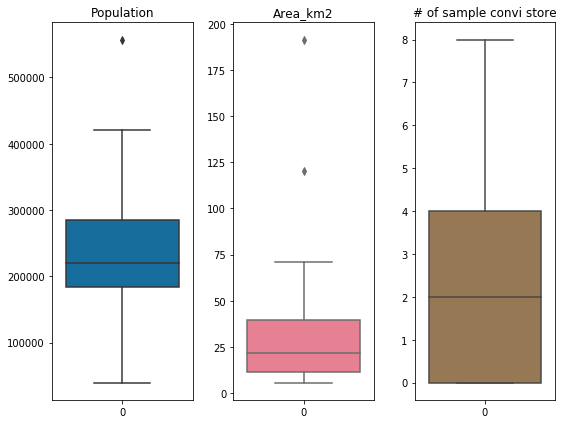

In [197]:
# Plotting range

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(131)
sns.boxplot(data=df_sub_merged['Population'], width=0.8, palette="colorblind").set_title('Population')

ax2 = fig.add_subplot(132)
sns.boxplot(data=df_sub_merged['Area_km2'], width=0.8, palette="husl").set_title('Area_km2')

ax3 = fig.add_subplot(133)
sns.boxplot(data=df_sub_merged['num_convi_store'], width=0.8, palette="cubehelix").set_title('# of sample convi store')

plt.tight_layout()
fig.show()

In [200]:
# we will normalize our data for clustering:
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(df_sub_merged[['Population','Area_km2', 'num_convi_store']].values)

df_cluster = pd.DataFrame(scaled_features, index=df_sub_merged.index, columns=df_sub_merged[['Population','Area_km2', 'num_convi_store']].columns)
df_cluster.head()

,Population,Area_km2,num_convi_store
0,2.781384,-0.335533,0.133593
1,1.281708,-0.503443,-0.283886
2,1.517177,-0.405525,1.386031
3,-0.171744,-0.764505,1.386031
4,1.584024,-0.419165,0.133593


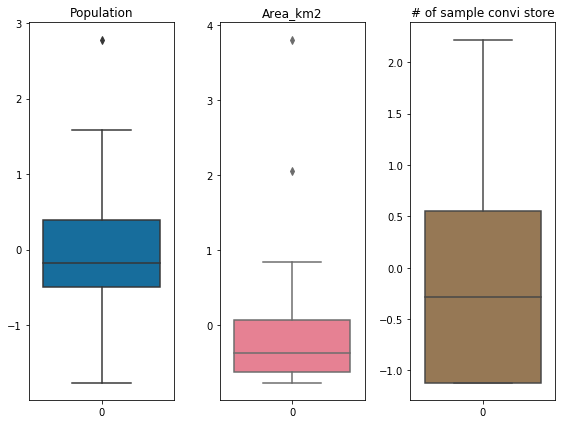

In [203]:
# Plotting range

fig_2 = plt.figure(figsize=(8, 6))
bx1 = fig_2.add_subplot(131)
sns.boxplot(data=df_cluster['Population'], width=0.8, palette="colorblind").set_title('Population')

bx2 = fig_2.add_subplot(132)
sns.boxplot(data=df_cluster['Area_km2'], width=0.8, palette="husl").set_title('Area_km2')

bx3 = fig_2.add_subplot(133)
sns.boxplot(data=df_cluster['num_convi_store'], width=0.8, palette="cubehelix").set_title('# of sample convi store')

plt.tight_layout()
fig_2.show()

From the plots we can see that distribution shape remain the same but the value ranges are different. 

This scaller is useful because our data have different units measure and now we removed the "units",

so that we can observe in fairer way.

## 2. Cluster data

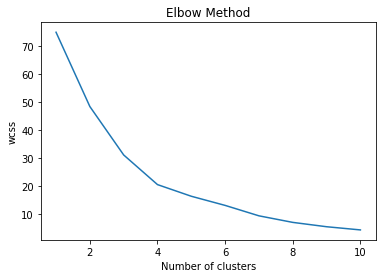

In [204]:
#Using the elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(df_cluster.values)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()b

From above plot, we decided to use K=4 as number of clusters.

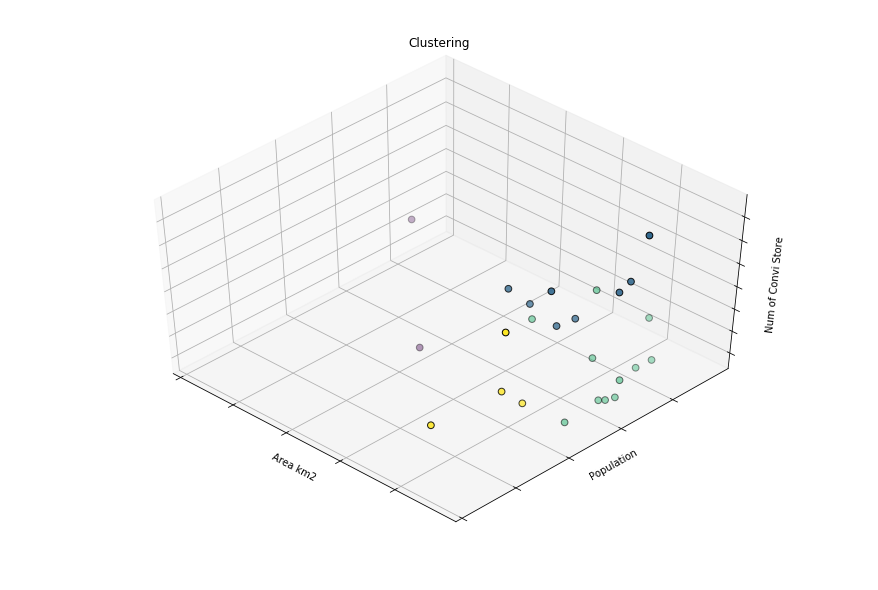

In [232]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6, 4))
ax = Axes3D(fig, rect=[0, 0, 2, 2], elev=50, azim=134)

ax.scatter(X[:, 1], X[:, 0], X[:, 2],
           c=y_means, edgecolor='k', s=45)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Area km2')
ax.set_ylabel('Population')
ax.set_zlabel('Num of Convi Store')
ax.set_title('Clustering')
ax.dist = 12

fig.show()

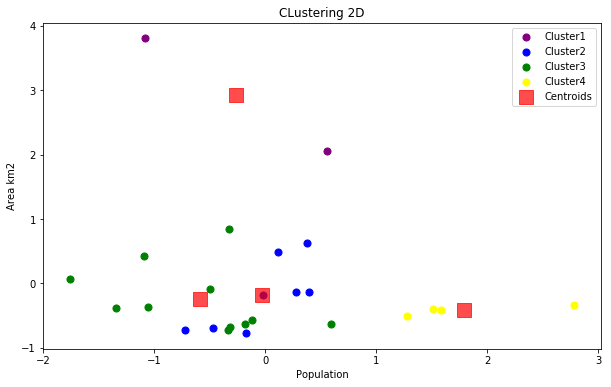

In [238]:
fig = plt.figure(figsize=(10, 6))
X = df_cluster.values
##Fitting kmeans to the dataset with k=4
km4=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = km4.fit_predict(X)
#Visualizing the clusters for k=4
plt.scatter(X[y_means==0,0],X[y_means==0,1],s=50, c='purple',label='Cluster1')
plt.scatter(X[y_means==1,0],X[y_means==1,1],s=50, c='blue',label='Cluster2')
plt.scatter(X[y_means==2,0],X[y_means==2,1],s=50, c='green',label='Cluster3')
plt.scatter(X[y_means==3,0],X[y_means==3,1],s=50, c='yellow',label='Cluster4')
plt.scatter(km4.cluster_centers_[:,0], km4.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
plt.title('CLustering 2D')
plt.xlabel('Population')
plt.ylabel('Area km2')
plt.legend()
plt.show()

In [241]:
y_means

array([3, 3, 3, 1, 3, 0, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2,
       1, 1, 1], dtype=int32)

In [242]:
copy_df = df_sub_merged.copy()
copy_df['Cluster Labels'] = pd.Series(y_means)
copy_df.head()

,index,Code,PartOf,English_Name,Type_P,Population,Latitude,Longitude,Area,num_convi_store,Area_km2,Cluster Labels
0,0,65000010,New Taipei City,Banqiao District,District,557120.0,25.009670,121.459099,23.1368 km2,3.0,23.1368,3
1,1,65000020,New Taipei City,Sanchong District,District,386236.0,25.061486,121.488102,16.3170 km2,2.0,16.3170,3
2,2,65000030,New Taipei City,Zhonghe District,District,413067.0,24.999397,121.498980,20.294 km2,6.0,20.2940,3
3,3,65000040,New Taipei City,Yonghe District,District,220619.0,25.009235,121.520070,5.7138 km2,6.0,5.7138,1
4,4,65000050,New Taipei City,Xinzhuang District,District,420684.0,25.035772,121.450248,19.74 km2,3.0,19.7400,3


In [268]:
copy_df[['Population', 'Area_km2', 'num_convi_store']].describe().T[['min','max']].T

,Population,Area_km2,num_convi_store
min,39555.0,5.7138,0.0
max,557120.0,191.4500,8.0


In [246]:
# take df from based on each cluster
df_cluster_1 = copy_df[copy_df['Cluster Labels'] == 0]
df_cluster_2 = copy_df[copy_df['Cluster Labels'] == 1]
df_cluster_3 = copy_df[copy_df['Cluster Labels'] == 2]
df_cluster_4 = copy_df[copy_df['Cluster Labels'] == 3]

In [260]:
df_cluster_1[['Population', 'Area_km2', 'num_convi_store']].describe().T

,count,mean,std,min,25%,50%,75%,max
Population,2.0,210105.50000,132255.131033,116587.0000,163346.250000,210105.50000,256864.750000,303624.00
Area_km2,2.0,155.83775,50.363327,120.2255,138.031625,155.83775,173.643875,191.45
num_convi_store,2.0,1.00000,1.414214,0.0000,0.500000,1.00000,1.500000,2.00


In [261]:
df_cluster_2[['Population', 'Area_km2', 'num_convi_store']].describe().T

,count,mean,std,min,25%,50%,75%,max
Population,8.0,237076.125000,46330.849178,157743.0000,212176.250000,245458.5000,274576.000000,285526.0000
Area_km2,8.0,29.251325,21.732360,5.7138,8.540925,30.5345,37.889425,62.3682
num_convi_store,8.0,5.375000,1.407886,4.0000,4.000000,5.5000,6.000000,8.0000


In [262]:
df_cluster_3[['Population', 'Area_km2', 'num_convi_store']].describe().T

,count,mean,std,min,25%,50%,75%,max
Population,11.0,173708.454545,75722.042996,39555.0000,118080.50000,202026.0000,211893.5000,307526.0000
Area_km2,11.0,26.722127,20.774064,7.4351,11.28455,21.1248,36.3094,71.2354
num_convi_store,11.0,0.727273,1.009050,0.0000,0.00000,0.0000,1.0000,3.0000


In [263]:
df_cluster_4[['Population', 'Area_km2', 'num_convi_store']].describe().T

,count,mean,std,min,25%,50%,75%,max
Population,4.0,444276.75000,76665.929153,386236.000,406359.25000,416875.500,454793.0000,557120.0000
Area_km2,4.0,19.87195,2.798360,16.317,18.88425,20.017,21.0047,23.1368
num_convi_store,4.0,3.50000,1.732051,2.000,2.75000,3.000,3.7500,6.0000


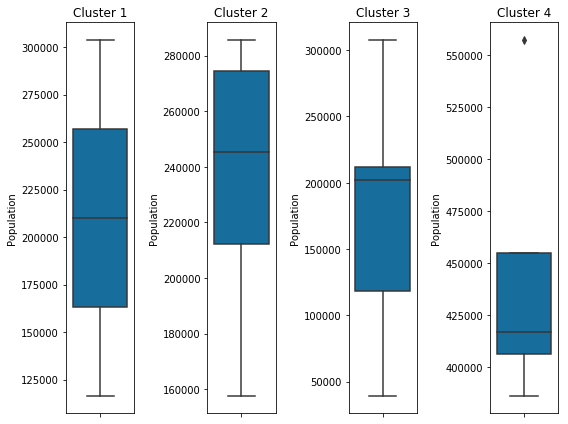

In [275]:
# Plotting range

fig_pop = plt.figure(figsize=(8, 6))

popx1 = fig_pop.add_subplot(141)
sns.boxplot(x=df_cluster_1['Population'], orient='v', width=0.8, palette="colorblind").set_title('Cluster 1')

popx2 = fig_pop.add_subplot(142)
sns.boxplot(x=df_cluster_2['Population'], orient='v', width=0.8, palette="colorblind").set_title('Cluster 2')

popx3 = fig_pop.add_subplot(143)
sns.boxplot(x=df_cluster_3['Population'], orient='v', width=0.8, palette="colorblind").set_title('Cluster 3')

popx4 = fig_pop.add_subplot(144)
sns.boxplot(x=df_cluster_4['Population'], orient='v', width=0.8, palette="colorblind").set_title('Cluster 4')

plt.tight_layout()
fig_pop.show()

From above plot we can derived:
    - Cluster 1: Mid 1 Population
    - Cluster 2: Mid 2 Population
    - Cluster 3: Small Population
    - CLuster 4: Large Population

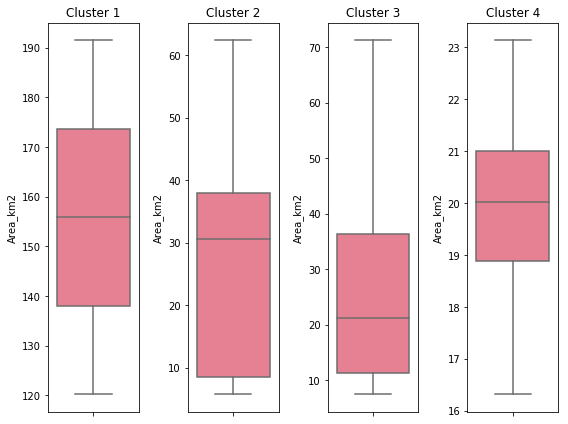

In [276]:
# Plotting range

fig_area = plt.figure(figsize=(8, 6))

areax1 = fig_area.add_subplot(141)
sns.boxplot(x=df_cluster_1['Area_km2'], orient='v', width=0.8, palette="husl").set_title('Cluster 1')

areax2 = fig_area.add_subplot(142)
sns.boxplot(x=df_cluster_2['Area_km2'], orient='v', width=0.8, palette="husl").set_title('Cluster 2')

areax3 = fig_area.add_subplot(143)
sns.boxplot(x=df_cluster_3['Area_km2'], orient='v', width=0.8, palette="husl").set_title('Cluster 3')

areax4 = fig_area.add_subplot(144)
sns.boxplot(x=df_cluster_4['Area_km2'], orient='v', width=0.8, palette="husl").set_title('Cluster 4')

plt.tight_layout()
fig_area.show()

From above plot we can derived:
    - Cluster 1: Large Area Size
    - Cluster 2: Mid 2 Area Size
    - Cluster 3: Mid 1 Area Size
    - CLuster 4: Small Area Size

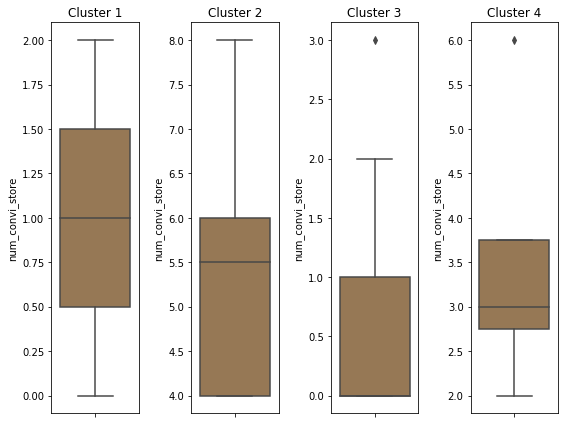

In [280]:
# Plotting range

fig_convi = plt.figure(figsize=(8, 6))

convix1 = fig_convi.add_subplot(141)
sns.boxplot(x=df_cluster_1['num_convi_store'], orient='v', width=0.8, palette="cubehelix").set_title('Cluster 1')

convix2 = fig_convi.add_subplot(142)
sns.boxplot(x=df_cluster_2['num_convi_store'], orient='v', width=0.8, palette="cubehelix").set_title('Cluster 2')

convix3 = fig_convi.add_subplot(143)
sns.boxplot(x=df_cluster_3['num_convi_store'], orient='v', width=0.8, palette="cubehelix").set_title('Cluster 3')

convix4 = fig_convi.add_subplot(144)
sns.boxplot(x=df_cluster_4['num_convi_store'], orient='v', width=0.8, palette="cubehelix").set_title('Cluster 4')

plt.tight_layout()
fig_convi.show()

From above plot we can derived:
    - Cluster 1: Mid 1 Number of convinience Store
    - Cluster 2: Big Number of Convinience Store
    - Cluster 3: Low Number of convinience Store
    - CLuster 4: Mid 2 Number of Convinience Store

## Analysis & Results <a name="analysis-results"></a>

#### Lets compute score, what we target is large area and large population but low number of available convinience store.

That case, we will give score 1-4 from low to big for Area and Population. 

Next for number of conviniece store we will give 1-4 from Large to small number of available Convience store.

| Label Cluster | Cluster | Population | Area km2 | Num of Convi | Total |
|-----|-----|-----|-----|-----|----- |
|  0  |  1  |  2  |  4  |  2  |  8   |
|  1  |  2  |  3  |  3  |  4  |  10  |
|  2  |  3  |  1  |  2  |  1  |  4   |
|  3  |  4  |  4  |  1  |  3  |  8   |

> From Table above, we can derived that our **Optimal location** are locations belong to **Cluster 2**
<br>
> As for Second choice of potential location are locations that belong to Cluster 1 / Cluster 4

In [282]:
# we use radius 1000 to avoid overlap between radius
center_taipei = [copy_df[copy_df['English_Name'] == 'Zhongzheng District']['Latitude'].values[0], copy_df[df_sub_merged['English_Name'] == 'Zhongzheng District']['Longitude'].values[0]]

map_taiwan_2 = folium.Map(location=center_taipei, zoom_start=13)
folium.Marker(center_taipei, popup='Alexanderplatz').add_to(map_taiwan_2)
for lat, lon, clust in zip(copy_df['Latitude'].tolist(), copy_df['Longitude'].tolist(), copy_df['Cluster Labels'].tolist()):
    if clust == 0:
        folium.Circle([lat, lon], radius = 1000 , color='yellow', fill=False).add_to(map_taiwan_2)
    elif clust == 1:
        folium.Circle([lat, lon], radius = 1000 , color='red', fill=False).add_to(map_taiwan_2)
    elif clust == 2:
        folium.Circle([lat, lon], radius = 1000 , color='blue', fill=False).add_to(map_taiwan_2)
    elif clust == 3:
        folium.Circle([lat, lon], radius = 1000 , color='yellow', fill=False).add_to(map_taiwan_2)
        
map_taiwan_2

In [289]:
print(copy_df[copy_df['Cluster Labels']==1]['English_Name'].values.tolist())

['Yonghe District', 'Tucheng District', 'Zhongzheng District', 'Wanhua District', 'Wenshan District', 'Neihu District', 'Shilin District', 'Beitou District']


**OUR OPTIMAL LOCATIONS CANDIDATE ARE:**
- Yonghe District
- Tucheng District
- Zhongzheng District
- Wanhua District
- Wenshan District
- Neihu District'
- Shilin District
- Beitou District

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Optimal Districts from Taipei or New Taipei City to open new Convinience store. 
Based on Population numbers, Area Size and extracting Number of existng of convience store from foursquare, we applied normalization to removed 'metrics' units of thos criterias. 
Next, Clustering of those Criterias was then performed in order to create candidate of interest (containing best potential locations) starting points for final exploration by stakeholders.

Our proposed best districs are: 'Yonghe District', 'Tucheng District', 'Zhongzheng District', 'Wanhua District', 'Wenshan District', 'Neihu District', 'Shilin District', 'Beitou District'.

Final decision on optimal districts location will be made by stakeholders based on specific characteristics in every recommended zone, 
taking into consideration additional factors like attractiveness of each location (other area facilities), levels of noise / proximity to major roads, real estate availability, etc.